In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import json
import re
import string
import nltk

from tqdm import tqdm
import joblib

In [9]:
def preprocess_text(text, stem=False):
    text = text.lower()
    # delete special characters
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    # delete links
    text = re.sub(r'http\S+', '', text)
    # delete multispaces
    text = re.sub('\s\s+', ' ', text)
    # delete digits
    text = re.sub(r'[0-9]+', '', text)
    # delete stop words
    text = text.split(' ')
    text = ' '.join([word for word in text if not word in STOPWORDS])
    
    text = remove_stopwords(text)
    if stem:
        stem = SnowballStemmer(language='english')
        text = ' '.join([stem.stem(word) for word in text.split(' ')])
    else:
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])
    text = text.strip()
    return text

import os.path

if not os.path.isfile('yelp_review_nostop_punc_engOnly_lem.csv') :
    yelp = pd.read_csv('yelp_review.csv')
    if 'Unnamed: 0' in yelp.columns:
        yelp = yelp.drop('Unnamed: 0', axis=1)
    for i in tqdm(range(len(yelp))):
        yelp.loc[i,'text']  = preprocess_text(yelp.loc[i,'text'], stem=False)
    yelp.to_csv('yelp_review_nostop_punc_engOnly_lem.csv')

yelp = pd.read_csv('yelp_review_nostop_punc_engOnly_lem.csv')

In [10]:
import random
from random import sample

random.seed(5)


(100, 234)

In [17]:
import time
from sklearn.cluster import KMeans, AgglomerativeClustering

df = pd.DataFrame(columns=['size', 'kmeans', 'agglomerative'])
for datasize in range(100, 10001, 1000):
    corpus = sample(yelp["text"].apply(str).to_list(), datasize)

    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=5,
        stop_words="english",
        )
    X_tfidf = vectorizer.fit_transform(corpus)
    
    print(datasize)
    start_time = time.time()
    kmeans = KMeans(
                n_clusters=10,
                max_iter=100,
                n_init=5,
            )
    kmeans.set_params(random_state=42)
    kmeans.fit(X_tfidf)
    kmeans_time = time.time() - start_time
    print("Kmeans: %s seconds " % (time.time() - start_time))
    
    start_time = time.time()
    agg = AgglomerativeClustering(distance_threshold=None, n_clusters=10)
    agg.fit(X_tfidf.toarray())
    agg_time = time.time() - start_time
    print("Agglomerative: %s seconds " % (time.time() - start_time))
    df.loc[len(df)] = [datasize, kmeans_time, agg_time]

100
Kmeans: 0.03471732139587402 seconds 
Agglomerative: 0.001583099365234375 seconds 
1100
Kmeans: 0.08223414421081543 seconds 
Agglomerative: 0.31906604766845703 seconds 
2100
Kmeans: 0.14761686325073242 seconds 
Agglomerative: 1.8373379707336426 seconds 
3100
Kmeans: 0.22657108306884766 seconds 
Agglomerative: 5.803086042404175 seconds 
4100
Kmeans: 0.2747797966003418 seconds 
Agglomerative: 11.448344945907593 seconds 
5100
Kmeans: 0.31874728202819824 seconds 
Agglomerative: 19.68850088119507 seconds 
6100
Kmeans: 0.47393321990966797 seconds 
Agglomerative: 30.009164094924927 seconds 
7100
Kmeans: 0.42559385299682617 seconds 
Agglomerative: 43.79142498970032 seconds 
8100
Kmeans: 0.6917083263397217 seconds 
Agglomerative: 61.44939589500427 seconds 
9100
Kmeans: 0.5446689128875732 seconds 
Agglomerative: 81.42019009590149 seconds 


In [18]:
df

,size,kmeans,agglomerative
0,100.0,0.034714,0.001582
1,1100.0,0.082231,0.319064
2,2100.0,0.147617,1.837337
3,3100.0,0.226567,5.803085
4,4100.0,0.274779,11.448344
5,5100.0,0.318746,19.688498
6,6100.0,0.473929,30.009160
7,7100.0,0.425592,43.791421
8,8100.0,0.691706,61.449392
9,9100.0,0.544668,81.420187


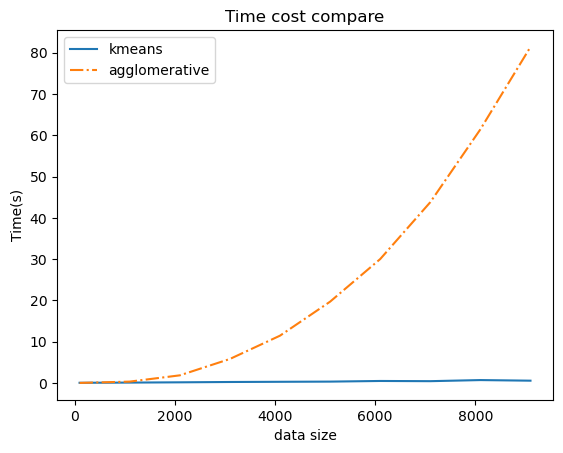

In [20]:
import matplotlib.pyplot as plt

plt.plot(df['size'], df['kmeans'], label ='kmeans')
plt.plot(df['size'], df['agglomerative'], '-.', label ='agglomerative')

plt.xlabel("data size")
plt.ylabel("Time(s)")
plt.legend()
plt.title('Time cost compare')
plt.show()